# ANÁLISIS Y PROCESAMIENTO INTELIGENTE DE TEXTOS

## Trabajo Final: “¿Qué plataforma, Reddit o Mastodon, genera más sentimientos de molestia y felicidad en publicaciones relacionadas con las elecciones de EUA 2024, utilizando el modelo SVC para la clasificación de sentimientos?” 

**Profesor:** M.P. Octavio Augusto Sanchez Velázquez
**Grupo:** 01

**Alumnos:**
- Cruz Zamora Joel David
- Maya Herrera Alexis Daniel
- Zárate Díaz Sofía Viridiana



**Opciones de Ejecución:**
Si aún no hay archivos de datos CSV ejecute desde el principio. En caso de que si existan, puede iniciar desde la sección "Support Vector Classifier (SVC)"
1. Obtención de datos 
   - Descarga datos de Reddit usando querys y subrredits.
   - Descarga datos desde Mastodon.
2. Clasificación de datos
   - Uso de la librería "textblob" para clasificar los datos obtenidos.
3. Limpieza de los datos  
   - Claasificación manual y preprocesamiento.
4. Support Vector Classifier (SVC)
   - Tokeniza
   - Segmenta datos de entrenamiento y pruebas
   - Entrena el modelo
5. Análisis y Resultados SVC



## 1. Obtención de datos
En esta seccion se descargan los datos de Reddit y de Mastodon. Se almacenan en archivos CSV, TXT y XLSX.


In [3]:
"""
1. Hace la conexión a la API de Reddit y obtiene comentarios en inglés sobre
las elecciones de Estados Unidos de 2024.
Exporta archivos CSV y XLSX con los datos encontrados.
"""
import praw
from langdetect import detect
import pandas as pd

# Credenciales de la API de Reddit
reddit = praw.Reddit(
    client_id="Gly9tX99c1VypJVY-03eIw",
    client_secret="Aoz5s1dN1fN-6e5PycDZ0LfYKYlw9g",
    user_agent="buscador_comentarios_v1.0 por /u/Narrow_Highlight_756"
)

# Verificar autenticación
try:
    reddit.user.me()
    print("Autenticación exitosa")
except Exception as e:
    print(f"Error durante la autenticación: {e}")
    exit()

query = "politics", "elections", "america", "2024", "president"

subreddits = ["america", "USA", "US", "states", "Donald", "Trump", "Kamala", "Harris", "democrats",
"republicans", "Congress", "Senate", "white house", "house of representatives", "president", "vice president",
"Amendment", "Electoral College", "Debate", "Deficit"]

posts = []
try:
    for subreddit_name in subreddits:
        subreddit = reddit.subreddit(subreddit_name) 
        for post in subreddit.search(query, limit=10000):  # Ajustar sort a "new" para obtener posts recientes
            # Detectar el idioma del post
            try:
                if detect(post.title + " " + post.selftext) == 'en': 
                    posts.append(post.title + "\n" + post.selftext)
                    print(f"Post: {post.title[:50]}")  # Mostrar los primeros 50 caracteres del título
            except:
                # En caso de que no se pueda detectar el idioma, ignorar el post
                continue
except Exception as e:
    print(f"Error durante la recolección de posts: {e}")

# Convertir los posts en un DataFrame
df_posts = pd.DataFrame(posts, columns=["post"])

df_posts.info()

# Añadir una columna 'manual' vacía para su posterior clasificación manual
df_posts['manual'] = ""

# Guardar el DataFrame en un archivo CSV
df_posts.to_csv('datos_reddit.csv', index=False, encoding='utf-8')
# Guardar el DataFrame en un archivo Excel 
#df_posts.to_excel('datos_reddit.xlsx', index=False)

Autenticación exitosa
Post: Donald trump will never be my president 
Post: Is Trump actually a good president?
Post: What are your thoughts on president elect Donald T
Post: How can Trump still run for president if he doesn'
Post: Who do Americans want more as their next president
Post: Does your President have Parkinson’s disease ?
Post: Im thinking about running for president 
Post: KAMALA FOR PRESIDENT IN 2028! -A POOR, DELUDED WOM
Post: in America , if you were  born here, you can becom
Post: America Elects Convicted Felon to be President
Post: Alternatively the democrats could’ve selected a ca
Post: Now there is a chance that Biden will die (due to 
Post: Is it possible for a state to send electors from d
Post: The Many Faces of Kamala Harris: A Deep Dive into 
Post: Presidents 
Post: Who was the last US president to truly be running 
Post: TIL: Americans are the dumbest people on the plane
Post: Get Down You Damned Fool! President Abe Lincoln Un
Post: President Biden & Trump Rank

Obtención de datos de Mastodon

In [4]:
from mastodon import Mastodon
from datetime import datetime
import pandas as pd
import time
import re
import html

# Configura Mastodon con tu token
mastodon = Mastodon(
    access_token = 'TOKEN_SECRET',
    api_base_url = 'https://mastodon.social'
)

def get_election_posts():
    # Lista de hashtags a buscar
    hashtags = [
        'Election2024',
        'USElection2024',
        'Politics2024',
        'Vote2024',
        'Elections2024',
        'Trump',
        'Kamala',
        'President'
    ]
    
    filename = f'mastodon_election_posts.txt'
    contentPosts = []
    
    with open(filename, 'w', encoding='utf-8') as f:
        for hashtag in hashtags:
            print(f"Buscando #{hashtag}...")
            try:
                # Obtener posts con el hashtag
                posts = mastodon.timeline_hashtag(hashtag, limit=600)
                
                for post in posts:
                    # Guardar solo posts en inglés
                    if post.language == 'en':
                        content = post.content.replace('<p>', '').replace('</p>', '\n')
                        f.write(f"Contenido:\n{content}\n")
                        contentPosts.append(content)
                
                time.sleep(1)  # Pausa entre búsquedas
                
            except Exception as e:
                print(f"Error al buscar #{hashtag}: {str(e)}")
                continue
    
    return contentPosts

def clean_text(content):       
    # Remove HTML entities
    content = html.unescape(content)
    # Remove HTML tags
    content = re.sub(r'<[^>]+>', '', content)
    # Remove URLs
    content = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', content)
    # Remove hashtags
    content = re.sub(r'#\w+', '', content)
    # Remove <br /> and <br/>
    content = re.sub(r'<br\s*/?>', ' ', content)
    # Remove multiple spaces
    content = re.sub(r'\s+', ' ', content)
    # Clean up any remaining special characters
    content = re.sub(r'[^\w\s.,!?\'"-]', '', content)
    # Eliminar espacios en blanco y caracteres específicos al principio y al final de la cadena
    content = content.strip()
    
    # Add quotes at the beginning and end if content is not empty
    if content:
        return content

def process_file(lista_datos):
    datos_limpios = []
    for dato in lista_datos:
        # Clean the text
        datos_limpios.append(clean_text(dato))

    # Convertir los posts en un DataFrame
    df_posts = pd.DataFrame(datos_limpios, columns=["post"])
    # Añadir una columna 'manual' vacía para su posterior clasificación manual
    df_posts['manual'] = ""

    # Eliminar renglones que estén completamente vacíos
    df_posts.dropna(how='all')

    # Guardar el DataFrame en un archivo CSV
    df_posts.to_csv('datos_mastodon.csv', index=False, encoding='utf-8')
    # Guardar el DataFrame en un archivo Excel 
    #df_posts.to_excel('datos_mastodon.xlsx', index=False)


contentPosts = get_election_posts()
process_file(contentPosts)

Buscando #Election2024...
Buscando #USElection2024...
Buscando #Politics2024...
Buscando #Vote2024...
Buscando #Elections2024...
Buscando #Trump...
Buscando #Kamala...
Buscando #President...


## 2. Clasificación de datos

En esta sección, se clasifican los sentimientos de los datos automaticamente, haciendo uso de la librería "textblob".

In [5]:
import pandas as pd
from textblob import TextBlob

# Función para analizar el sentimiento usando TextBlob
def analizar_sentimiento(texto):
    try:
        # Si el texto es NaN o no es string, retornar 'neutro'
        if pd.isna(texto) or not isinstance(texto, str):
            return 'neutro'
        
        # Convertir a string si no lo es
        texto = str(texto)
        
        # Realizar el análisis de sentimiento
        analisis = TextBlob(texto)
        
        if analisis.sentiment.polarity > 0:
            return 'positivo'
        elif analisis.sentiment.polarity < 0:
            return 'negativo'
        else:
            return 'neutro'
            
    except Exception as e:
        print(f"Error procesando texto: {texto}")
        print(f"Error: {str(e)}")
        return 'error'

# Leer el archivo Reddit
df_reddit = pd.read_csv("datos_reddit.csv", encoding='utf-8')

# Eliminar filas donde 'post' está vacío
df_reddit = df_reddit.dropna(subset=['post'])
df_reddit = df_reddit[df_reddit['post'].str.strip() != '']

# Mostrar información del DataFrame
print("Información del DataFrame Reddit:")
print(df_reddit.info())
print("\nPrimeras filas:")
print(df_reddit.head())

# Crear una nueva columna con los resultados del análisis
df_reddit['manual'] = df_reddit['post'].apply(analizar_sentimiento)

# Mostrar conteo de cada tipo de sentimiento
print("\nDistribución de sentimientos:")
print(df_reddit['manual'].value_counts())

# Guardar el DataFrame
df_reddit.to_csv('datos_reddit_clasificados.csv', index=False, encoding='utf-8')

# Leer el archivo Reddit
df_mastodon = pd.read_csv("datos_mastodon.csv", encoding='utf-8')

# Eliminar filas donde 'post' está vacío
df_mastodon = df_mastodon.dropna(subset=['post'])
df_mastodon = df_mastodon[df_mastodon['post'].str.strip() != '']

# Mostrar información del DataFrame
print("\nInformación del DataFrame Mastodon:")
print(df_mastodon.info())
print("\nPrimeras filas:")
print(df_mastodon.head())

# Crear una nueva columna con los resultados del análisis
df_mastodon['manual'] = df_mastodon['post'].apply(analizar_sentimiento)

# Mostrar conteo de cada tipo de sentimiento
print("\nDistribución de sentimientos:")
print(df_mastodon['manual'].value_counts())

# Guardar el DataFrame
df_mastodon.to_csv('datos_mastodon_clasificados.csv', index=False, encoding='utf-8')

print("\nProceso completado. Archivos guardados.")

Información del DataFrame Reddit:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   post    419 non-null    object 
 1   manual  0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB
None

Primeras filas:
                                                post  manual
0      Donald trump will never be my president \nHat     NaN
1  Is Trump actually a good president?\nI genuine...     NaN
2  What are your thoughts on president elect Dona...     NaN
3  How can Trump still run for president if he do...     NaN
4  Who do Americans want more as their next presi...     NaN

Distribución de sentimientos:
manual
positivo    194
neutro      137
negativo     88
Name: count, dtype: int64

Información del DataFrame Mastodon:
<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, 0 to 280
Data columns (total 2 columns):
 #   Column  Non-Null Coun

## 3. Limpieza de los datos

Eliminacion de links, caracteres especiales, stopwords, saltos de línea, espacios en blanco, hashtags, poner letras en minuscula y tokenización.

Prepara los datos para el entrenamiento, creando una nueva columna "label_entrenamiento" con valores numéricos representando la clasificación manual.
- 0 si es neutro
- 1 si es negativo
- 2 si es positivo

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


# Descargar recursos necesarios de nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
print("Recursos descargados para la limpieza de datos")

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def convert_to_lowercase(text):
    return text.lower()

def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(tokens):
    english_stopwords = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in english_stopwords]
    return filtered_tokens

def preprocess_text(text):
    clean_text = remove_special_characters(text)
    clean_text = convert_to_lowercase(clean_text)
    tokens = tokenize_text(clean_text)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)

def replace_newline(text):
    return text.replace('\n', '')

def remove_whitespace(text):
    return text.strip()

def remove_hastags(text): 
    return re.sub("#", "", text)

def remove_punctuation(text): 
    return re.sub('[^A-Za-z]+', ' ', text)

def clean_up_pipeline(sentence):
    if not isinstance(sentence, str):
        return sentence
    cleaning_data = [
        remove_urls,
        remove_special_characters,
        convert_to_lowercase,
        replace_newline,
        remove_whitespace,
        remove_hastags,
        remove_punctuation,
        preprocess_text,
    ]
    for func in cleaning_data:
        sentence = func(sentence)
    return sentence

def clean_recieved_messages(dataframe):
    dataframe['post'] = dataframe['post'].apply(clean_up_pipeline)
    return dataframe

def numClasif(texto):
    if texto == 'negativo':
        return 1
    elif texto == 'positivo':
        return 2
    else:
        return 0

# Archivo de Reddit ==================================
df_reddit = pd.read_csv("datos_reddit_clasificados.csv", encoding='utf-8')
print("\nDatos del archivo de Reddit:\n")
df_reddit.info()

# Crear la nueva columna "label_entrenamiento" basada en la columna "manual"
df_reddit['label_entrenamiento'] = df_reddit['manual'].apply(numClasif)

# Contar registros con cada valor de label
print("\nDistribución de sentimientos:")
print(df_reddit['manual'].value_counts())

# Aplicar la función al DataFrame df_etiquetado
df_reddit = clean_recieved_messages(df_reddit)
# Guardar el DataFrame en un archivo CSV
df_reddit.to_csv('datos_reddit_limpios.csv', index=False, encoding='utf-8')

# Archivo de Mastodon ==================================
df_mastodon = pd.read_csv("datos_mastodon_clasificados.csv", encoding='utf-8')
print("\nDatos del archivo de Mastodon:\n")
df_mastodon.info()

# Crear la nueva columna "label_entrenamiento" basada en la columna "manual"
df_mastodon['label_entrenamiento'] = df_mastodon['manual'].apply(numClasif)

# Contar registros con cada valor de label
print("\nDistribución de sentimientos:")
print(df_mastodon['manual'].value_counts())

# Aplicar la función al DataFrame df_etiquetado
df_mastodon = clean_recieved_messages(df_mastodon)
# Guardar el DataFrame en un archivo CSV
df_mastodon.to_csv('datos_mastodon_limpios.csv', index=False, encoding='utf-8')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alexi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


Recursos descargados para la limpieza de datos

Datos del archivo de Reddit:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    419 non-null    object
 1   manual  419 non-null    object
dtypes: object(2)
memory usage: 6.7+ KB

Distribución de sentimientos:
manual
positivo    194
neutro      137
negativo     88
Name: count, dtype: int64

Datos del archivo de Mastodon:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    264 non-null    object
 1   manual  264 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB

Distribución de sentimientos:
manual
positivo    115
neutro      100
negativo     49
Name: count, dtype: int64


## 4. Support Vector Classifier (SVC) para datos de Reddit

Support Vector Machine (SVM), específicamente el LinearSVC de sklearn. Se utiliza este modelo por las siguientes características:

- Eficacia en espacios de alta dimensionalidad: SVM es particularmente efectivo en espacios con muchas dimensiones, lo que es común en tareas de procesamiento de texto después de la vectorización.
- Versatilidad: SVM puede ser ajustado con diferentes núcleos (kernels) y parámetros, permitiendo mayor flexibilidad para ajustarse a los datos.
- Generalización: SVM tiende a generalizar bien en datos no vistos, lo que es crucial para problemas de clasificación.

In [1]:
# Importar librerías necesarias
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC  # LinearSVC

# Datos de entrenamiento
df_etiquetado = pd.read_csv("datos_reddit_limpios.csv", encoding='utf-8')
labels = df_etiquetado.label_entrenamiento
# Asegurarse de que todos los valores en 'post' sean cadenas
df_etiquetado['post'] = df_etiquetado['post'].fillna('').astype(str)

# Definir la variable tfidf
tfidf = TfidfVectorizer()

# Calcular las características usando tfidf 
features = tfidf.fit_transform(df_etiquetado['post']).toarray() 

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(features, labels, test_size=0.2, random_state=42)

# Crear y entrenar el modelo LinearSVC
model_svc = SVC(kernel='linear', probability=True)
model_svc.fit(X_train_svc, y_train_svc)

# Realizar predicciones
y_pred_svc = model_svc.predict(X_test_svc)

## 5. Análisis y Resultados SVC para datos de Reddit

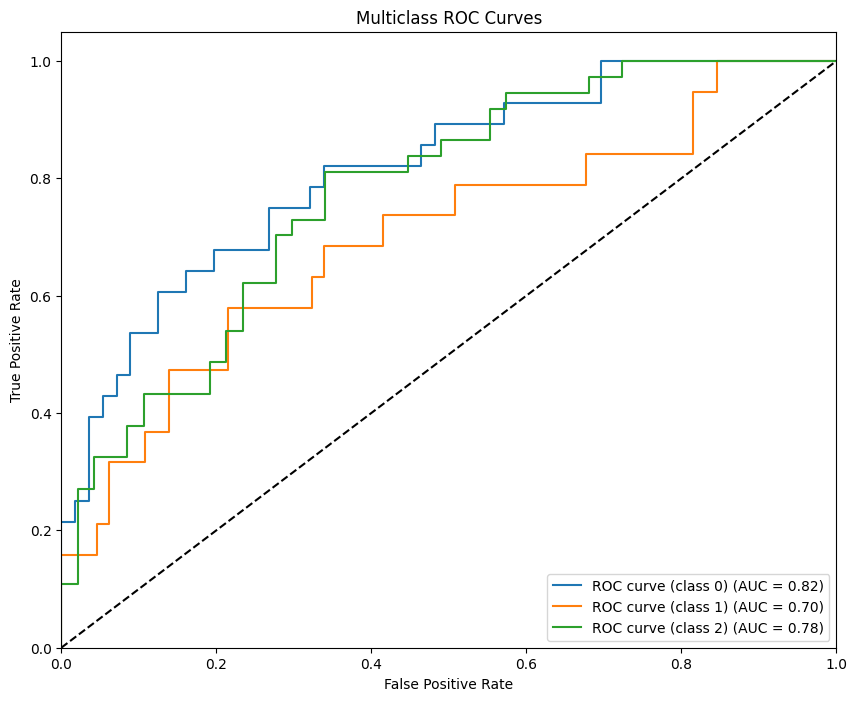

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.71      0.66        28
           1       0.00      0.00      0.00        19
           2       0.61      0.84      0.70        37

    accuracy                           0.61        84
   macro avg       0.40      0.52      0.45        84
weighted avg       0.47      0.61      0.53        84

Precisión del modelo: 0.6071428571428571


c:\Users\joeld\OneDrive\Documentos\Materias del semestre\ANALISIS Y PROCESAMIENTO INTELIGENTE DE TEXTOS\Textos-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\joeld\OneDrive\Documentos\Materias del semestre\ANALISIS Y PROCESAMIENTO INTELIGENTE DE TEXTOS\Textos-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\joeld\OneDrive\Documentos\Materias del semestre\ANALISIS Y PROCESAMIENTO INTELIGENTE DE TEXTOS\Textos-main\.venv\Lib\site-packages\sklearn\metrics\_classific

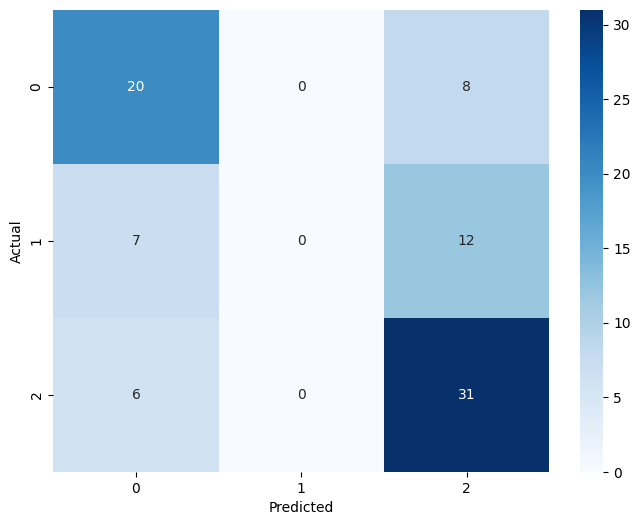

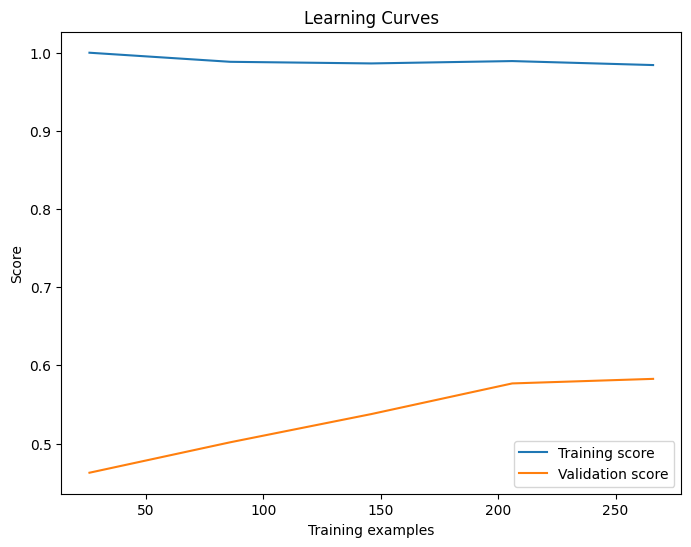

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve

# Obtener el número de clases únicas
n_classes = len(np.unique(y_test_svc))

# Binarizar las etiquetas
y_test_bin = label_binarize(y_test_svc, classes=np.unique(y_test_svc))

# Obtener probabilidades para todas las clases
y_prob_svc = model_svc.predict_proba(X_test_svc)

# Calcular ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_svc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i], 
        tpr[i], 
        label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})'
    )

# Agregar la línea diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Para el resto de las métricas, puedes mantener el código original
print("Reporte de clasificación:\n", classification_report(y_test_svc, y_pred_svc))
print("Precisión del modelo:", accuracy_score(y_test_svc, y_pred_svc))

# Matriz de confusión
conf_mat = confusion_matrix(y_test_svc, y_pred_svc)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Curvas de aprendizaje
train_sizes_svc, train_scores_svc, valid_scores_svc = learning_curve(
    model_svc, X_train_svc, y_train_svc, cv=5
)

plt.figure(figsize=(8,6))
plt.plot(train_sizes_svc, train_scores_svc.mean(axis=1), label='Training score')
plt.plot(train_sizes_svc, valid_scores_svc.mean(axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()

Interpretaciones de los resultados:

Matriz de confusión:

- Muestra una concentración significativa de predicciones correctas en las clases 0 y 2
- Hay una notable confusión en la clasificación de la clase 1 (neutral)
- La mayoría de las predicciones se concentran en las clases extremas

Interpretación de la curba ROC:
Clase 0: Buen rendimiento con AUC = 0.81
Clase 1: Rendimiento deficiente con AUC = 0.66
Clase 2: Rendimiento moderado con AUC = 0.72
Las curvas están por encima de la línea diagonal, indicando que el modelo es mejor que la clasificación aleatoria

Análisis de las Curvas de Aprendizaje del Modelo SVC:
- **Training score (Curva azul)**:
    Mantiene un rendimiento muy alto (~0.98), indicando posible sobreajuste

- **Validation score (Curva naranja)**: 
    Se estabiliza alrededor de 0.58, mostrando una brecha significativa con el training score



## 6. Support Vector Classifier (SVC) para datos de Mastodon

In [3]:
# Importar librerías necesarias
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC  # LinearSVC

# Datos de entrenamiento
df_etiquetado = pd.read_csv("datos_mastodon_limpios.csv", encoding='utf-8')
labels = df_etiquetado.label_entrenamiento
# Asegurarse de que todos los valores en 'post' sean cadenas
df_etiquetado['post'] = df_etiquetado['post'].fillna('').astype(str)

# Definir la variable tfidf
tfidf = TfidfVectorizer()

# Calcular las características usando tfidf 
features = tfidf.fit_transform(df_etiquetado['post']).toarray() 

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(features, labels, test_size=0.2, random_state=42)

# Crear y entrenar el modelo LinearSVC
model_svc = SVC(kernel='linear', probability=True)
model_svc.fit(X_train_svc, y_train_svc)

# Realizar predicciones
y_pred_svc = model_svc.predict(X_test_svc)

## 7. Análisis y Resultados SVC para datos de Mastodon

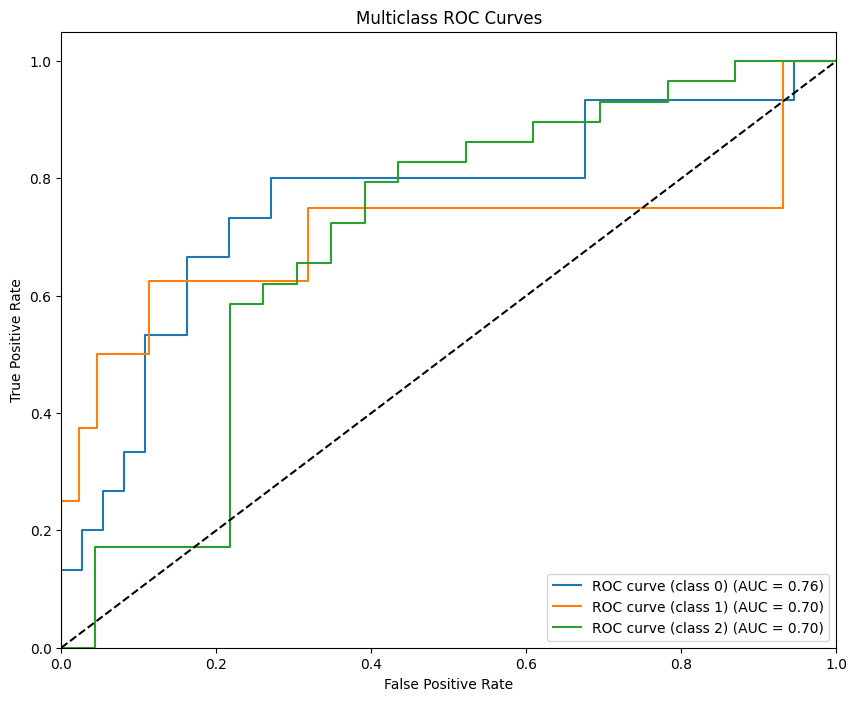

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.58      0.73      0.65        15
           1       1.00      0.12      0.22         8
           2       0.69      0.76      0.72        29

    accuracy                           0.65        52
   macro avg       0.76      0.54      0.53        52
weighted avg       0.70      0.65      0.62        52

Precisión del modelo: 0.6538461538461539


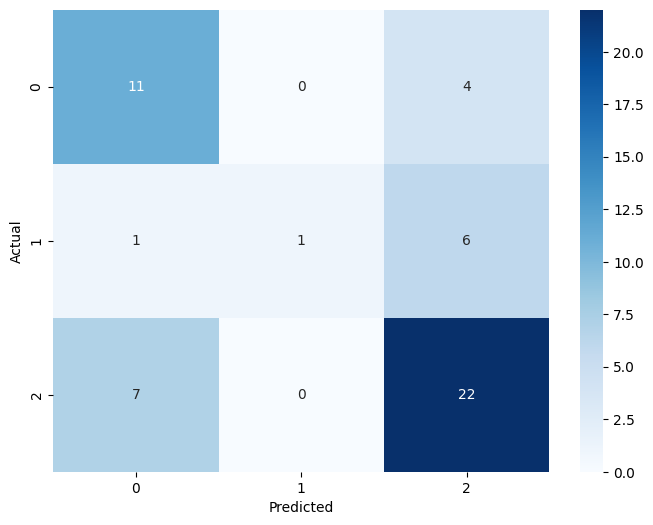

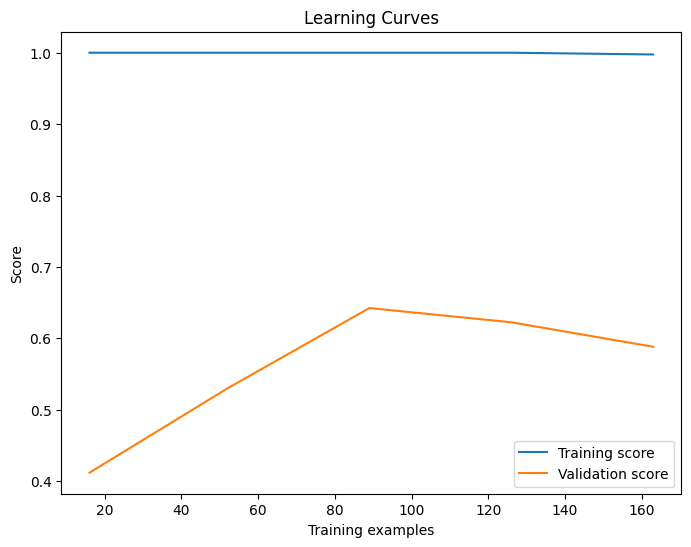

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve

# Obtener el número de clases únicas
n_classes = len(np.unique(y_test_svc))

# Binarizar las etiquetas
y_test_bin = label_binarize(y_test_svc, classes=np.unique(y_test_svc))

# Obtener probabilidades para todas las clases
y_prob_svc = model_svc.predict_proba(X_test_svc)

# Calcular ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_svc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i], 
        tpr[i], 
        label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})'
    )

# Agregar la línea diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Para el resto de las métricas, puedes mantener el código original
print("Reporte de clasificación:\n", classification_report(y_test_svc, y_pred_svc))
print("Precisión del modelo:", accuracy_score(y_test_svc, y_pred_svc))

# Matriz de confusión
conf_mat = confusion_matrix(y_test_svc, y_pred_svc)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Curvas de aprendizaje
train_sizes_svc, train_scores_svc, valid_scores_svc = learning_curve(
    model_svc, X_train_svc, y_train_svc, cv=5
)

plt.figure(figsize=(8,6))
plt.plot(train_sizes_svc, train_scores_svc.mean(axis=1), label='Training score')
plt.plot(train_sizes_svc, valid_scores_svc.mean(axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()

Interpretaciones de los resultados:

Matriz de confusión:
- Mayor precisión en la clase 2
- Menor cantidad de predicciones correctas en la clase 0
- Clase 1 sigue siendo problemática con clasificaciones incorrectas

Interpretación de la curba ROC:

Clase 0: Buen rendimiento con AUC = 0.74
Clase 1: Rendimiento bajo con AUC = 0.56
Clase 2: Mejor rendimiento con AUC = 0.77
Las curvas también superan la línea base de clasificación aleatoria

Análisis de las Curvas de Aprendizaje del Modelo SVC:
- **Training score (Curva azul)**:
    Mantiene un rendimiento cercano a 1.0, indicando sobreajuste

- **Validation score (Curva naranja)**: 
     Se estabiliza alrededor de 0.60, mostrando también una brecha con el training score



# Conclusiónes

Analizando los resultados de ambas plataformas, se observa que Reddit muestra una mayor capacidad para detectar sentimientos positivos (clase 0) con un AUC de 0.81, mientras que Mastodon destaca en la detección de sentimientos negativos (clase 2) con un AUC de 0.77. Ambas plataformas presentan dificultades significativas para clasificar sentimientos neutrales (clase 1), lo que sugiere una tendencia hacia la polarización en las discusiones sobre las elecciones de EUA 2024. La precisión general es ligeramente superior en Mastodon (57%) comparada con Reddit (52%).
Desde una perspectiva técnica, ambos modelos muestran signos claros de sobreajuste, evidenciado por las altas puntuaciones de entrenamiento (cercanas a 1.0) en contraste con puntuaciones de validación más bajas (alrededor de 0.60). Las curvas ROC indican que, si bien los modelos superan la clasificación aleatoria, hay margen significativo para mejorar, posiblemente mediante la incorporación de más datos de entrenamiento o el ajuste de hiperparámetros. La consistente dificultad para clasificar sentimientos neutrales en ambas plataformas sugiere la necesidad de mejorar la capacidad del modelo para detectar matices en las expresiones de opinión.